In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ramadhany","key":"2ddda528b740a3ebf713a27547172309"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d akshaydattatraykhare/diabetes-dataset

Dataset URL: https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset
License(s): CC0-1.0
  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 20.3MB/s]


In [ ]:
!unzip diabetes-dataset.zip -d /content/

Archive:  diabetes-dataset.zip
  inflating: /content/diabetes.csv   


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
import pickle

In [ ]:
df = pd.read_csv('/content/diabetes.csv')

In [ ]:
# Random sampling for only 5 rows
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
713,0,134,58,20,291,26.4,0.352,21,0
407,0,101,62,0,0,21.9,0.336,25,0
209,7,184,84,33,0,35.5,0.355,41,1
610,3,106,54,21,158,30.9,0.292,24,0
306,10,161,68,23,132,25.5,0.326,47,1


In [ ]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## Exploratory Data Analysis

### How is the correlation between features in the data ?

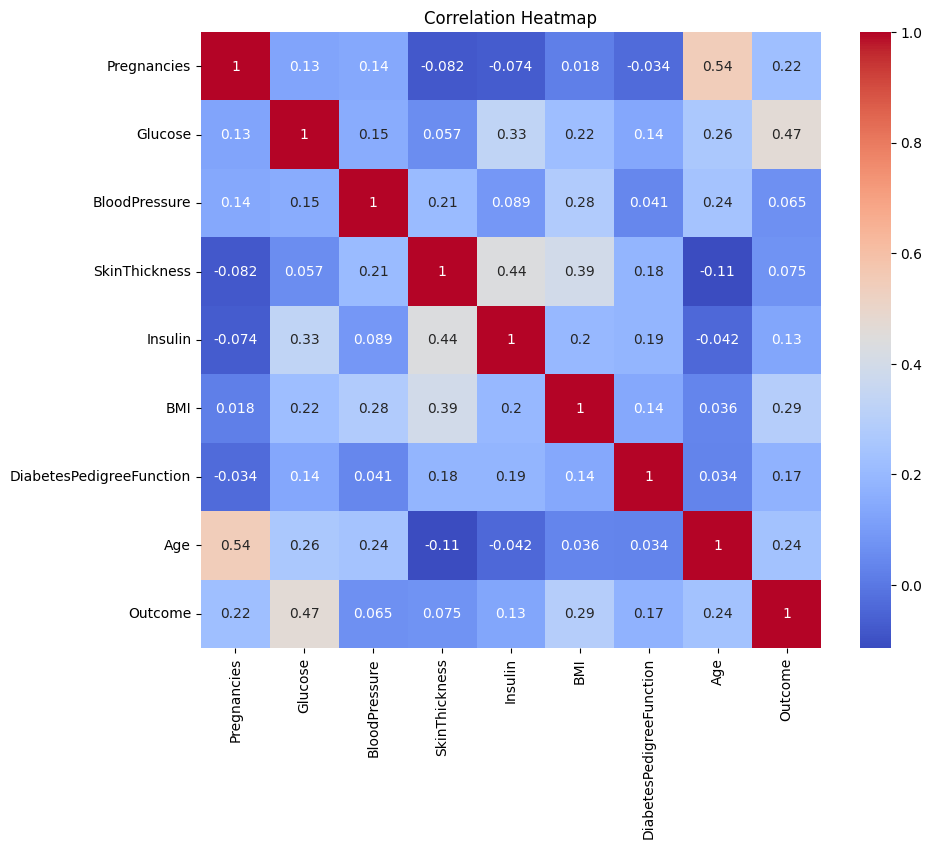

In [ ]:
# View correlation of each feature in the data
corr = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Based on the correlation heatmap above, there is few features that had strong positive correlation with other feature in this data.

### How many patients have diabetes and those who don't?

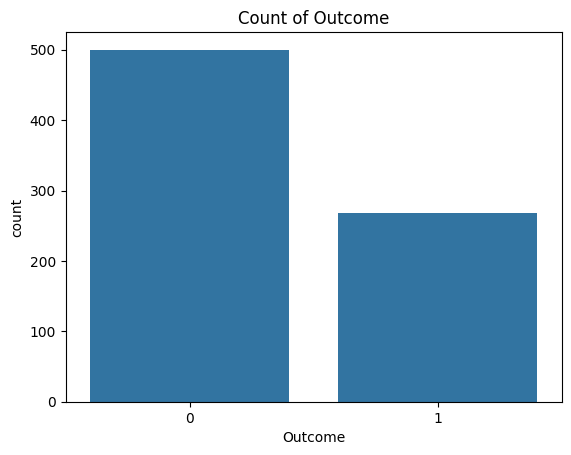

In [ ]:
# Create countplot to view the count of each outcome
sns.countplot(x='Outcome', data=df)
plt.title('Count of Outcome')
plt.show()

Based on the bar chart, there is more number of non diabetes patient than diabetes patient in this data

### What is the average age, body mass index, glucose, insulin, diabetes dedigree dunction, pregnancues and blood pressure levels of patients with diabetes ?

In [ ]:
# Create pivot table to calculate age, BMI, glucose, insulin and blood pressure based on outcome
pivot_table = df.pivot_table(index='Outcome', aggfunc='mean')

In [ ]:
pivot_table

,Age,BMI,BloodPressure,DiabetesPedigreeFunction,Glucose,Insulin,Pregnancies,SkinThickness
Outcome,,,,,,,,
0,31.190000,30.304200,68.184000,0.429734,109.980000,68.792000,3.298000,19.664000
1,37.067164,35.142537,70.824627,0.550500,141.257463,100.335821,4.865672,22.164179


Based on the pivot table above, patients with diabetes have a higher average value for each feature than patients who do not have diabetes

### How is the data distribution for each feature

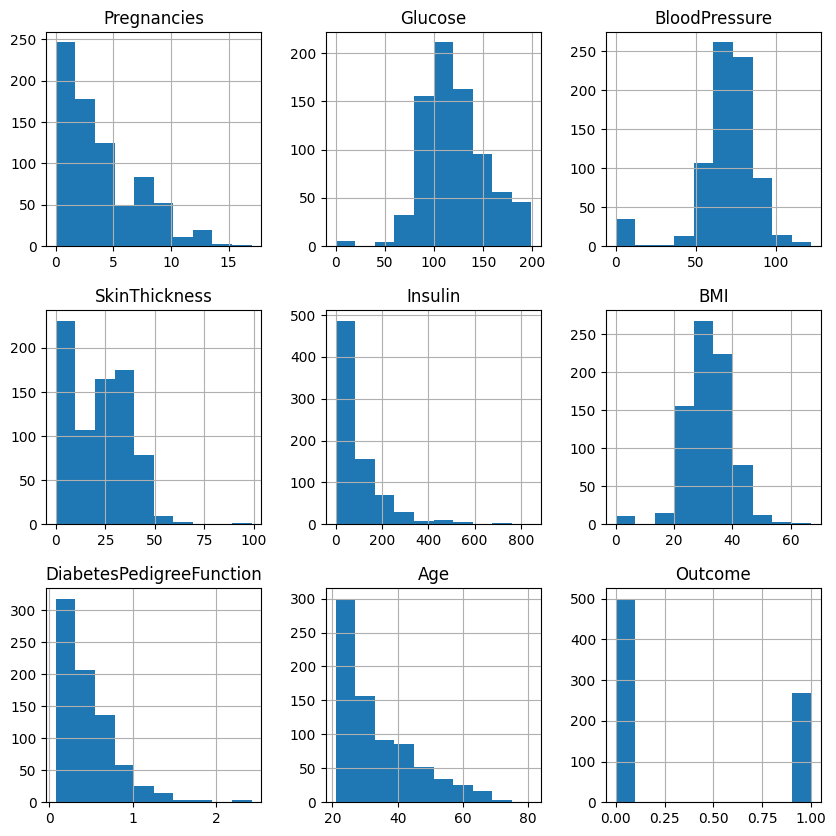

In [ ]:
# create histogram for each feature
df.hist(figsize=(10, 10))
plt.show()

Based on some histograms above, there are outliers in several features. Let's look further with boxplots

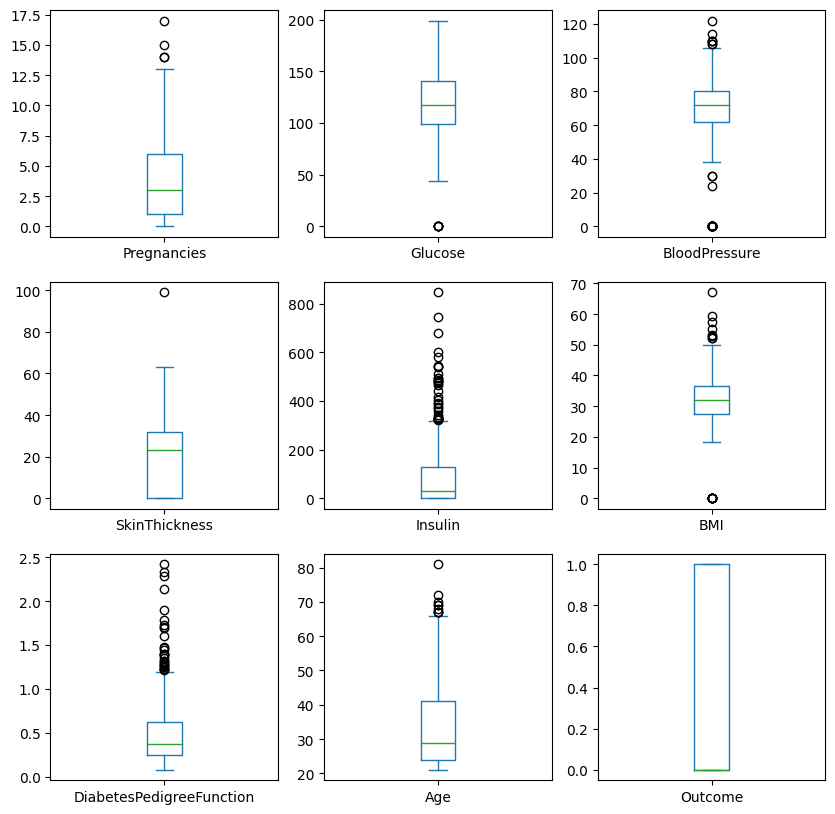

In [ ]:
# Create boxplot to view outlier of the features
df.plot(kind='box', subplots=True, layout=(3, 3), figsize=(10, 10))
plt.show()

Based on the boxplot above, there is few patients with 0 glucose.

In [ ]:
# remove outlier in BMI feature using IQR
Q1 = df['BMI'].quantile(0.25)
Q3 = df['BMI'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['BMI'] >= Q1 - 1.5 * IQR) & (df['BMI'] <= Q3 + 1.5 * IQR)]

### Data Splitting

In [ ]:
# Split the data into train and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

#### Feature Engineering

In [ ]:
# Feature Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Train Test Split

In [ ]:
# split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

## Model Training

### XGBoost Model

In [ ]:
# XGBoost model
xgb_model = xgb.XGBClassifier(learning_rate=0.1,n_estimators=100,max_depth=5)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Predict using the trained model
y_pred_xg = xgb_model.predict(X_test)

## Model Evaluation

### XGBoost model

In [ ]:
# Classification report
print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       104
           1       0.72      0.74      0.73        46

    accuracy                           0.83       150
   macro avg       0.80      0.81      0.81       150
weighted avg       0.83      0.83      0.83       150



Text(50.722222222222214, 0.5, 'True')

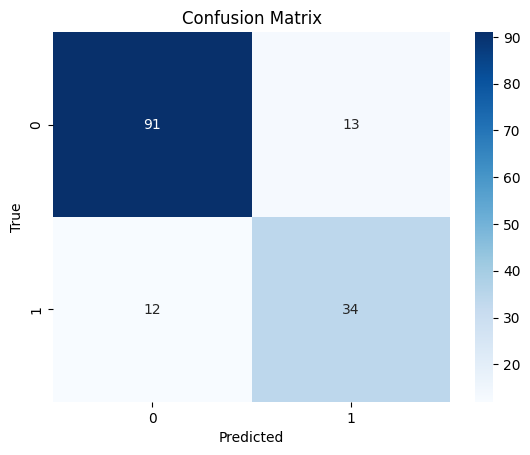

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_xg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
# Predict probabilities for the positive class
y_probs_xg = xgb_model.predict_proba(X_test)[:, 1]

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_probs_xg)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

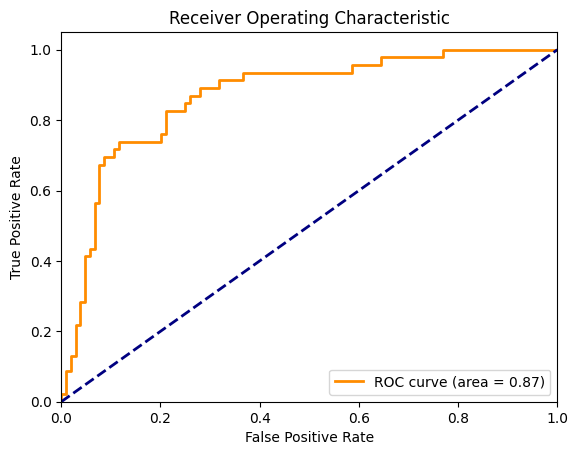

In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Export the trained model

In [ ]:
# export the trained model using pickle
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

In [ ]:
# export scaler using pickle
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)